<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# Base Classifier with Augmented Data

by Fabian Märki

## Summary
The aim of this notebook is to see if the *Base Classifiers's* performance can be improved by extending the training data with *augmented data*. 

This notebook does not contain assigments: <font color='red'>Enjoy.</font>

<a href="https://colab.research.google.com/github/markif/2024_FS_CAS_NLP_LAB_Notebooks/blob/master/06_c_Base_Classifier_with_Augmented_Data.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'

from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.text import join_tokens


import pandas as pd
import numpy as np

In [2]:
from fhnw.nlp.utils.system import set_log_level
from fhnw.nlp.utils.system import system_info

set_log_level()
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 5.13.0-41-generic
Python version: 3.8.10
CPU cores: 6
RAM: 31.13GB total and 11.61GB available
Tensorflow version: 2.8.0
GPU is available
GPU is a NVIDIA GeForce RTX 2070 with Max-Q Design with 8192MiB


In [3]:
%%time
download("https://drive.switch.ch/index.php/s/0hE8wO4FbfGIJld/download", "data/german_doctor_reviews_tokenized.parq")
data = load_dataframe("data/german_doctor_reviews_tokenized.parq")

download("https://drive.switch.ch/index.php/s/hBWWTOmhqoHbflL/download", "data/german_doctor_reviews_augmented_tokenized.parq")
data_aug = load_dataframe("data/german_doctor_reviews_augmented_tokenized.parq")

CPU times: user 22.7 s, sys: 3.47 s, total: 26.2 s
Wall time: 18 s


In [4]:
# remove all neutral sentimens
data = data.loc[(data["label"] != "neutral")]
data.shape

(331187, 10)

In [5]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, woche, muenchen, zahn, ...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerde, rücken, magura, erster, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


In [6]:
data_aug.head(3)

,text_original,rating,sentiment,text,label,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,-1,Dieser Arzt ist das unmöglichste was mir in me...,negative,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,-1,Dieser Arzt ist das unmöglichste was mir in me...,negative,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,-1,Dieser Arzt ist das unmöglichste was mir in me...,negative,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."


Prepare the data (train/test split).Define *random_state* to have the same splits among different runs.

In [7]:
from sklearn.model_selection import train_test_split

# ensure we retain the class weights by using stratify
data_train, data_test = train_test_split(data, shuffle=True, random_state=42, stratify=data["label"])

In [8]:
data_train = pd.concat([data_train, data_aug])
X_train, y_train = data_train["token_lemma"], data_train["label"]
X_test, y_test = data_test["token_lemma"], data_test["label"]

Check if dataset is unbalanced. 

In [9]:
val_counts = pd.concat([data, data_aug])["label"].value_counts().sort_index()
val_counts

negative    329956
positive    298165
Name: label, dtype: int64

negative    0.525306
positive    0.474694
Name: label, dtype: float64


<AxesSubplot:>

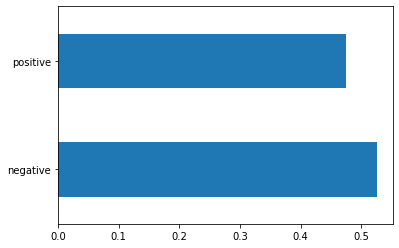

In [10]:
val_counts = val_counts / np.sum(val_counts)
print(val_counts)
val_counts.plot(kind='barh')

Looks *better*.

### Base Classifier

Prepare the data (train/test split).

In [11]:
from sklearn.model_selection import train_test_split

# ensure we retain the class weights by using stratify
# define random_state to have the same splits among different runs
data_train, data_test = train_test_split(data, shuffle=True, random_state=42, stratify=data["label"])

In [12]:
data_train = pd.concat([data_train, data_aug])
X_train, y_train = data_train["token_lemma"], data_train["label"]
X_test, y_test = data_test["token_lemma"], data_test["label"]

Let's use the parameters we found through hyperparameter tuning.

In [13]:
%%time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

pipe = Pipeline([
         ("vec", CountVectorizer(ngram_range=(1, 2), tokenizer=lambda x: x,preprocessor=lambda x: x, stop_words=None, token_pattern=None)),
         ('tfidf', TfidfTransformer()),
         ("clf", SGDClassifier())
        ])

CPU times: user 19.5 ms, sys: 7.9 ms, total: 27.4 ms
Wall time: 25.8 ms


In [14]:
best_params = {
    "clf__alpha": 5.3e-06, 
    "tfidf__norm": "l2", 
    "tfidf__sublinear_tf": True, 
    "tfidf__use_idf": True, 
    "vec__max_df": 0.5, 
    "vec__min_df": 0.0001,
}


#best_params = {'max_df': 0.75,
# 'min_df': 0.00056,
# 'alpha': 6.0e-05,
# 'use_idf': False,
# 'norm': 'l2',
# 'sublinear_tf': True
#}

In [15]:
%%time

pipe.set_params(**best_params)

pipe.fit(X_train, y_train)

CPU times: user 38.4 s, sys: 2.82 s, total: 41.2 s
Wall time: 40.2 s


Pipeline(steps=[('vec',
                 CountVectorizer(max_df=0.5, min_df=0.0001, ngram_range=(1, 2),
                                 preprocessor=<function <lambda> at 0x7f008415e700>,
                                 tokenizer=<function <lambda> at 0x7f00844d9f70>)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('clf', SGDClassifier(alpha=5.3e-06))])

In [16]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [17]:
from sklearn.metrics import classification_report

report = classification_report(y_train, y_train_pred)
print("Train:")
print(report)
report = classification_report(y_test, y_test_pred)
print("Test:")
print(report)

Train:
              precision    recall  f1-score   support

    negative       0.99      0.99      0.99    321700
    positive       0.99      0.99      0.99    223624

    accuracy                           0.99    545324
   macro avg       0.99      0.99      0.99    545324
weighted avg       0.99      0.99      0.99    545324

Test:
              precision    recall  f1-score   support

    negative       0.85      0.90      0.87      8256
    positive       0.99      0.98      0.99     74541

    accuracy                           0.97     82797
   macro avg       0.92      0.94      0.93     82797
weighted avg       0.98      0.97      0.97     82797



Set Population: 545324
Accuracy: 0.9897


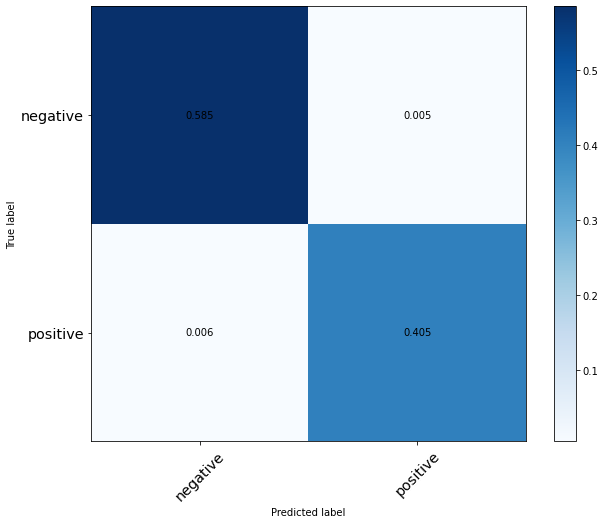

Set Population: 82797
Accuracy: 0.9742


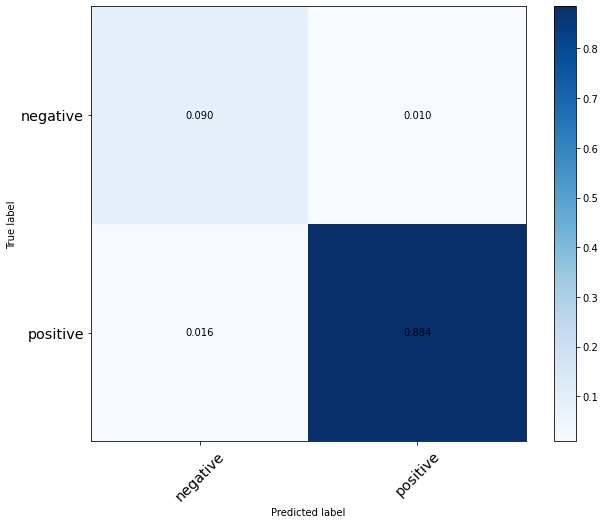

In [18]:
from fhnw.nlp.utils.ploting import plot_confusion_matrix

plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)